In [1]:
from matplotlib import pyplot as plt
import numpy as np
import mbore

%load_ext autoreload
%autoreload 2

In [2]:
def latent(gamma):
    """
    Forrester's.
    """
    # return (6.0*gamma-2.0)**2 * np.sin(12.0 * gamma - 4.0)
    return np.sin(3.0*gamma) + gamma**2 - 0.7*gamma

num_index_points = 1024
num_features = 1
x_min, x_max = -1.0, 2.0

n_train = 200

seed = 8888  # set random seed for reproducibility
random_state = np.random.RandomState(seed)

Xte = np.linspace(x_min, x_max, num_index_points).reshape(-1, num_features)
Yte = latent(Xte).squeeze()

Xtr = np.linspace(x_min, x_max, n_train).reshape(-1, num_features)
Ytr = latent(Xtr).squeeze()

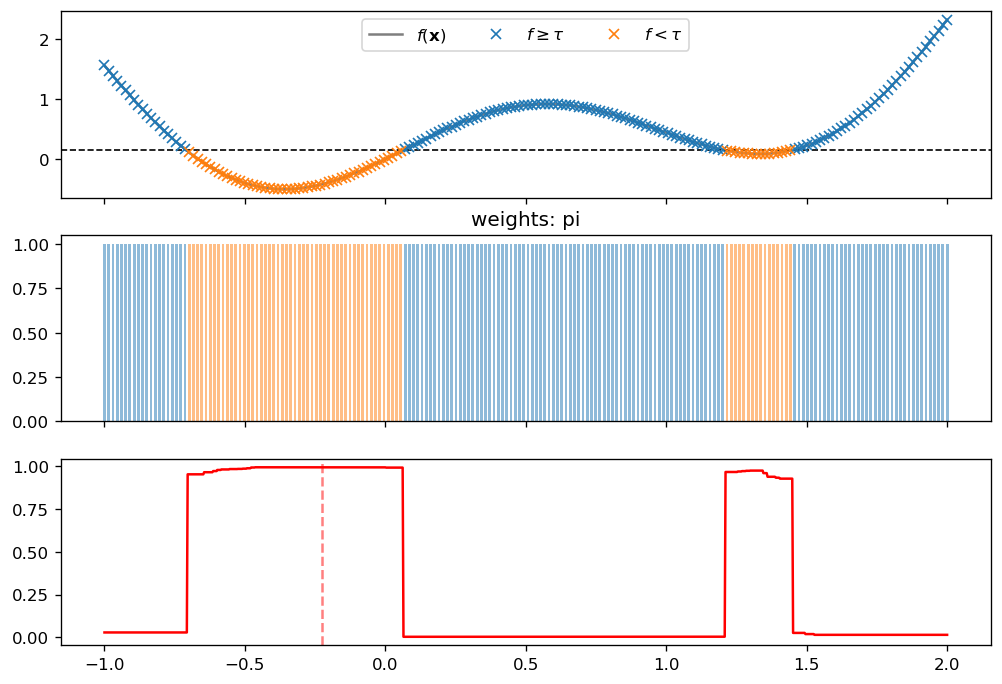

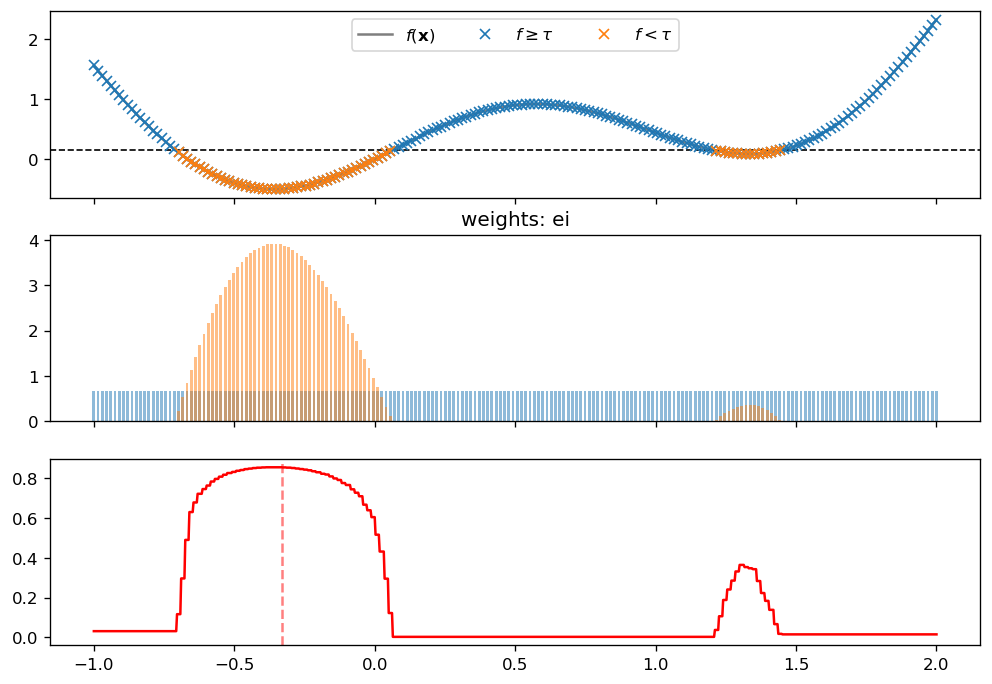

In [4]:
gamma = 1/3

for weight_type in ['pi', 'ei']:
    # training data
    X = Xtr.copy()
    y = Ytr.copy()

    # problem bounds and opt budget
    lb, ub = np.full(1, -1), np.full(1, 2)
    opt_budget = 10000

    # get the model weights (all equal for "pi", not for "ei")
    x, y, z, w, tau = mbore.util.load_classification_data(X, y, gamma, weight_type=weight_type)

    # define and train the classifier
    clf = mbore.classifiers.XGBoostClassifier(Xtr=x, class_labels=z, weights=w)
    clf.train()
    
    # instantiate the optimiser, here we use random search and take the argmax (boltzman_sample=False is argmax)
    opt = mbore.optimizers.RandomSearchOptimizer(clf, lb, ub, opt_budget, boltzman_sample=False)
    Xnext = opt.get_xnext()

    # just some plotting
    fig, (ax, axb, axpred) = plt.subplots(3, 1, figsize=(10, 7), sharex=True, dpi=120) # type:ignore

    ax.plot(Xte, Yte, 'tab:gray', label=r"$f(\mathbf{x})$", zorder=-2)
    ax.plot(x[~z], y[~z], 'x', c='tab:blue', label=r"$f \geq \tau$")
    ax.plot(x[z], y[z], 'x', c='tab:orange', label=r"$f < \tau$")
    ax.axhline(tau, ls='--', c='k', alpha=1, lw=1, zorder=-1)
    ax.legend(ncol=3, loc='upper center')

    axb.bar(x[~z].ravel(), height=w[~z].ravel(), width=0.01, alpha=0.5)
    axb.bar(x[z].ravel(), height=w[z].ravel(), width=0.01, alpha=0.5)
    axb.set_title(f"weights: {weight_type}")

    axpred.plot(Xte, clf.predict(Xte), c='r')
    axpred.axvline(Xnext, c='r', ls='--', alpha=0.5)

    plt.show()